In [5]:
import json
from matplotlib import pyplot as plt
import numpy as np
import open3d as o3d
from src.EmbryoAlignment import Embryo

with open('data/corresptissues.json') as f:
    corres_tissues = json.load(f)
    corres_tissues = {eval(k): v for k, v in corres_tissues.items()}
with open('data/tissuescolor.json') as f:
    colors_paper = json.load(f)
    colors_paper = {eval(k): v for k, v in colors_paper.items()}
%matplotlib notebook

# Setting up parameters

In [6]:
# Path to the input data
data_path = '../SpatialSC/Data/E8.5.h5ad'
# Path to the output folder
output_folder = 'out/'

# Set of genes that will be interpolated
genes_of_interest = ['Actb', 'T', 'Cdx2',
                     'Fgf8','Mesp2', 'Tbx6', 'Meox1',
                     'Uncx','Tbx18', 'Sox2', 'Nkx6-2',
                     'Sox1', 'Otx2','Tnnt2', 'Shh',
                     'Foxa2', 'Sox17', 'Gapdh']

# List of tissues that are ignored to do coverslip registration
tissues_to_ignore = [13, 15, 16, 22, 27, 29, 32, 36, 40, 41]

# Coverslips to ignore
# on the starting side
nb_CS_begin_ignore = 0
# on the ending side
nb_CS_end_ignore = 2

# Gives more weight to some tissues to help the alignment
tissue_weight = {21:1000, 18:1000}
# xy resolution
xy_resolution = .6
# Distance max that two beads can be linked together between coverslips
th_d = 150
# Threshold bellow which the beads will be considered noise.
# Value between 0 (all beads taken) and 1 (almost no beads taken)
outlier_threshold = .1

# Number of interpolated layers between two consecutive coverslips
nb_interp = 5

In [7]:
embryo = Embryo(data_path, tissues_to_ignore, corres_tissues, tissue_weight=tissue_weight,
                xy_resolution=xy_resolution, genes_of_interest=genes_of_interest,
                nb_CS_begin_ignore=nb_CS_begin_ignore, nb_CS_end_ignore=nb_CS_end_ignore,
                store_anndata=True)
embryo.removing_spatial_outliers(th=outlier_threshold)
embryo.set_zpos()
embryo.reconstruct_intermediate(embryo, th_d=th_d, genes=genes_of_interest)

<IPython.core.display.Javascript object>


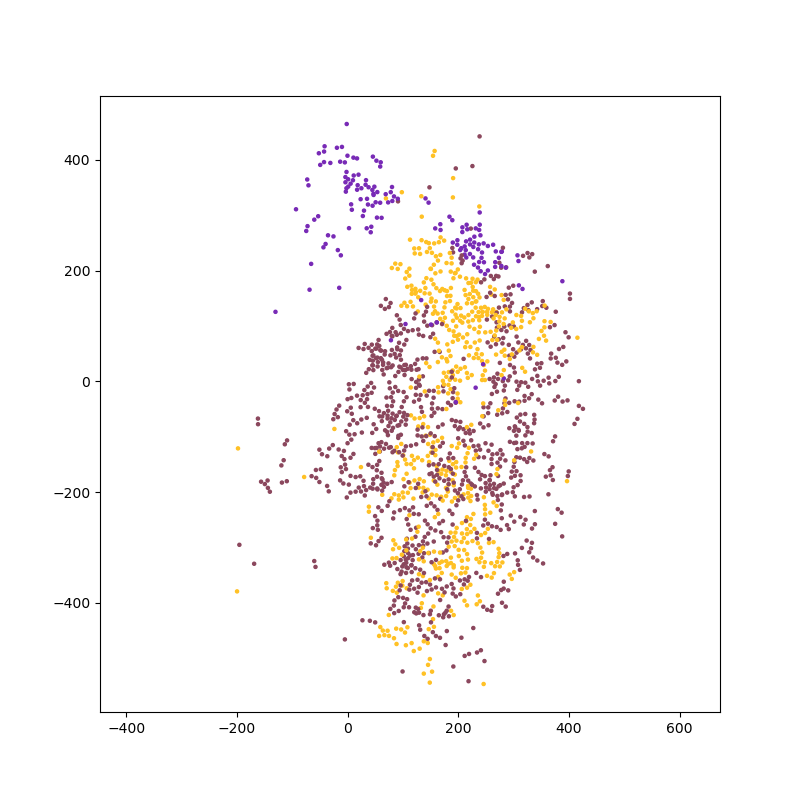

<IPython.core.display.Javascript object>


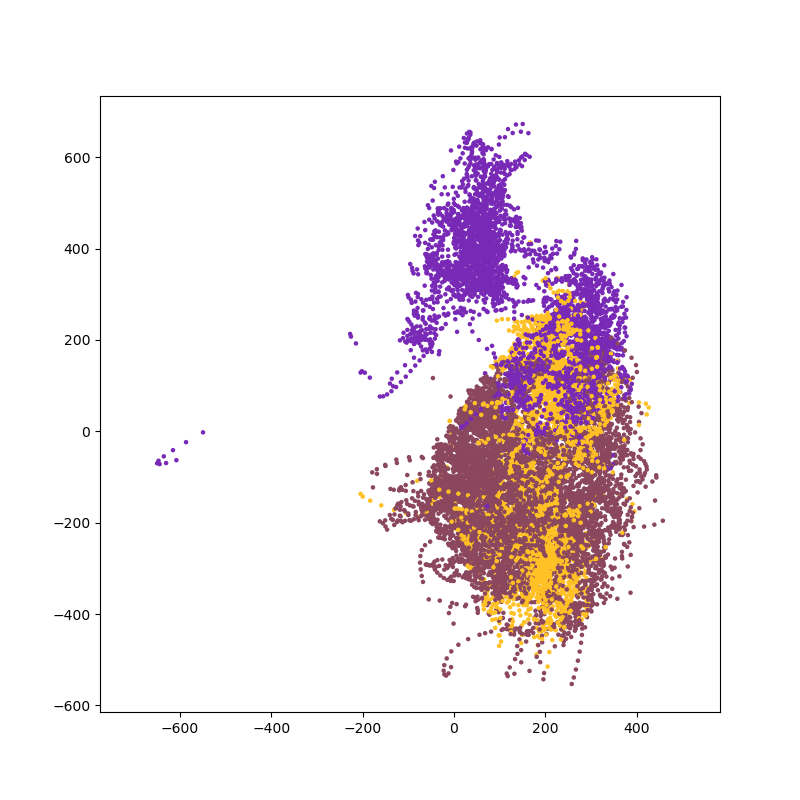

/home/guignard/miniconda3/envs/SpatialSCII/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/guignard/miniconda3/envs/SpatialSCII/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted.id' as categorical


In [8]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = np.array([-5., 5., 0.])
points_to_plot = embryo.plot_slice([5, 0, 0], color_map=colors_paper, origin=origin,
                                   tissues=[18, 30, 31], nb_interp=0)

points_to_plot = embryo.ply_slice('out/slice.ply', angles, colors_paper, origin=origin,
                                  tissues_colored=[18, 30, 31],
                                  tissues=[18, 21, 30, 31, 34], nb_interp=5)


points_to_plot = embryo.plot_slice(angles, color_map=colors_paper, origin=origin, thickness=50,
                                   tissues=[18, 30, 31], nb_interp=5)

points_to_plot = embryo.anndata_slice('out/slice.h5ad', angles,
                                      gene_list=genes_of_interest, origin=origin,
                                      tissues=[18, 21, 30, 31, 34], nb_interp=5)

embryo.anndata_no_extra('out/all.h5ad', angles, origin=origin)

# Build point clouds

## Grey point cloud

In [4]:
# ploting all the tissues
# if one wants to plot a subset the list below can be uncomented and changed
# tissues_to_plot = [1, 2, 3, 4]
tissues_to_plot = embryo.all_tissues

# Creates the interpolation
points, colors = embryo.produce_em(nb_interp, tissues_to_plot)

# Create the pointcloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector([[.8,.8,.8],]*len(points))

# Saving the pointcloud
o3d.io.write_point_cloud("out/All-tissues-independent/grey.ply", pcd)


True

## Tissue colored point cloud

In [5]:
# individual ploting a subset of tissues with the tissue color
# one wants to plot a subset the list below can be uncomented
# tissues_to_plot = embryo.all_tissues
tissues_to_plot = [18, 21, 30, 31, 34]

for t in tissues_to_plot:
    tissues_to_plot = [t]
    points, colors = embryo.produce_em(nb_interp, tissues_to_plot)
    if len(colors)<1:
        continue
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector([colors_paper[ci] for ci in colors])

    o3d.io.write_point_cloud(f"out/All-tissues-independent/{corres_tissues[t]}.ply", pcd)

In [125]:
# individual ploting a subset of tissues with the tissue color
# one wants to plot a subset the list below can be uncomented
# tissues_to_plot = embryo.all_tissues
tissues_to_plot = [18, 21, 30, 31, 34]

points, colors = embryo.produce_em(nb_interp, tissues_to_plot)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector([colors_paper[ci] for ci in colors])

o3d.io.write_point_cloud(f"out/few_tissues.ply", pcd)

True

## Gene expression colored point clouds

In [9]:
# List of genes to plot
genes_of_interest = ['Actb', 'T', 'Cdx2',
                     'Fgf8','Mesp2', 'Tbx6', 'Meox1',
                     'Uncx','Tbx18', 'Sox2', 'Nkx6-2',
                     'Sox1', 'Otx2','Tnnt2', 'Shh',
                     'Foxa2', 'Sox17', 'Gapdh']
# Colormap used
# (see https://matplotlib.org/stable/tutorials/colors/colormaps.html for an extensive list of colormaps)
cm = plt.cm.viridis

for gene in genes_of_interest:#[18, 21, 30, 31, 34]:
    tissues_to_plot = [18, 21, 30, 31, 34]
    points, colors = embryo.produce_em(nb_interp, tissues_to_plot=tissues_to_plot, gene=gene)

    c_min, c_max = np.percentile(colors, 1), np.percentile(colors, 99)
    color_from_v = lambda v, c_min, c_max, cm: cm((v-c_min)/(c_max-c_min))[...,:-1]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(color_from_v(np.array(colors), c_min, c_max, cm))

#     o3d.io.write_point_cloud(f"out/genes/{gene}.ply", pcd)

# Bonus: How to run multiple parameters at once:

In [13]:
# Tissues to plot in the pointcloud
tissues_to_plot = [18, 21, 30, 31, 34]
th_to_test = [.05, .1, .15, .2]

for test_outlier_th in th_to_test[:1]:
    # Load and reconstruct
    embryo = Embryo(data_path, tissues_to_ignore, corres_tissues, tissue_weight=tissue_weight,
                    xy_resolution=xy_resolution, genes_of_interest=genes_of_interest,
                    nb_CS_begin_ignore=nb_CS_begin_ignore, nb_CS_end_ignore=nb_CS_end_ignore)
    embryo.removing_spatial_outliers(th=test_outlier_th)
    embryo.set_zpos()
    embryo.reconstruct_intermediate(embryo, th_d=th_d, genes=genes_of_interest)
    
    # Writing the point cloud
    points, colors = embryo.produce_em(nb_interp, tissues_to_plot)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector([colors_paper[ci] for ci in colors])

    # Make sure to have created the folder test-outlier-th before
    o3d.io.write_point_cloud(f"out/test-outlier-th/th_{th_to_test}.ply", pcd)

data kept
[Open3D WARNING] Write PLY failed: unable to open file: out/test-outlier-th/th_[0.05, 0.1, 0.15, 0.2].ply


RPly: Unable to create file


# Extracting a plan

In [5]:
import transformations as tr
def plot_slice(embryo, angle, rot_orig=[0, 0, 1], origin=[0, 0, 0],
               thickness=30, tissues=None, angle_unit='degree',
               nb_interp=5):
    if tissues is None:
        tissues = embryo.all_tissues
    if angle_unit == 'degree':
        angle = np.deg2rad(angle)
    x_angle, y_angle, z_angle = angle
    rot_x = tr.rotation_matrix_py(x_angle, [1, 0, 0], origin)
    rot_y = tr.rotation_matrix_py(y_angle, [0, 1, 0], origin)
    rot_z = tr.rotation_matrix_py(z_angle, [0, 0, 1], origin)
    rot_composed = rot_x@rot_y@rot_z
    new_axis = (np.hstack([rot_orig, 0])@rot_composed)[:-1]
    equation = lambda pos: np.sum(new_axis*pos, axis=1)-origin@new_axis
    points, color = embryo.produce_em(nb_interp, tissues)
    points = np.array(points)
    color = np.array(color)
    plan = (np.abs(equation(points))<thickness)
    points_to_plot = points[plan]
    points_to_plot = (np.hstack([points_to_plot, [[0]]*points_to_plot.shape[0]])@rot_composed)[:, :-1]
    color_to_plot = [colors_paper[c] for c in color[plan]]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)#, projection='3d')
    ax.scatter(*(points_to_plot.T[:-1]), s=5, color=color_to_plot)
    ax.axis('equal')
    return points_to_plot

def ply_slice(embryo, file_name, angle, rot_orig=[0, 0, 1],
              origin=[0, 0, 0], thickness=30, tissues=None,
              tissues_colored=None, angle_unit='degree',
              nb_interp=5):
    if tissues is None:
        tissues = embryo.all_tissues
    if tissues_colored is None:
        tissues = embryo.all_tissues
    if angle_unit == 'degree':
        angle = np.deg2rad(angle)
    x_angle, y_angle, z_angle = angle
    rot_x = tr.rotation_matrix_py(x_angle, [1, 0, 0], origin)
    rot_y = tr.rotation_matrix_py(y_angle, [0, 1, 0], origin)
    rot_z = tr.rotation_matrix_py(z_angle, [0, 0, 1], origin)
    rot_composed = rot_x@rot_y@rot_z
    new_axis = (np.hstack([rot_orig, 0])@rot_composed)[:-1]
    equation = lambda pos: np.sum(new_axis*pos, axis=1)-origin@new_axis
    points, color = embryo.produce_em(nb_interp, tissues)
    points = np.array(points)
    color = np.array(color)
    plan = (np.abs(equation(points))<thickness)
    points_to_plot = points[plan]
    color_to_plot = color[plan]
    mapping = np.array([[.8, .8, .8] for t in range(max(colors_paper)+1)])
    for t in tissues_colored:
        mapping[t] = colors_paper.get(t, [.8, .8, .8])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_to_plot)
    pcd.colors = o3d.utility.Vector3dVector(mapping[color_to_plot])
    o3d.io.write_point_cloud(file_name, pcd)
    
    return points_to_plot

def anndata_slice(embryo, file_name, angle, gene_list, rot_orig=[0, 0, 1],
                  origin=[0, 0, 0], thickness=30, tissues=None,
                  angle_unit='degree', nb_interp=5):
    if tissues is None:
        tissues = embryo.all_tissues
    if angle_unit == 'degree':
        angle = np.deg2rad(angle)
    x_angle, y_angle, z_angle = angle
    rot_x = tr.rotation_matrix_py(x_angle, [1, 0, 0], origin)
    rot_y = tr.rotation_matrix_py(y_angle, [0, 1, 0], origin)
    rot_z = tr.rotation_matrix_py(z_angle, [0, 0, 1], origin)
    rot_composed = rot_x@rot_y@rot_z
    new_axis = (np.hstack([rot_orig, 0])@rot_composed)[:-1]
    equation = lambda pos: np.sum(new_axis*pos, axis=1)-origin@new_axis
    points, colors, genes = embryo.produce_em(5, tissues_to_plot, gene_list=genes_of_interest)
    points = np.array(points)
    colors = np.array(colors)
    genes = np.array(genes)
    plan = (np.abs(equation(points))<thickness)
    points_to_plot = points[plan]
    points_to_plot = (np.hstack([points_to_plot, [[0]]*points_to_plot.shape[0]])@rot_composed)[:, :-1]
    color_to_plot = colors[plan]
    genes_to_plot = genes.T[plan]
    df = pd.DataFrame(genes_to_plot, columns=genes_of_interest)
    D = anndata.AnnData(df)
    D.obsm['X_Spatial'] = points_to_plot
    D.obs['predicted.id'] = [str(k) for k in color_to_plot]
    D.write(file_name)

    return points_to_plot

def anndata_no_extra(embryo, file_name, angle, rot_orig=[0, 0, 1],
                     origin=[0, 0, 0], thickness=30, angle_unit='degree'):
    if angle_unit == 'degree':
        angle = np.deg2rad(angle)
    x_angle, y_angle, z_angle = angle
    rot_x = tr.rotation_matrix_py(x_angle, [1, 0, 0], origin)
    rot_y = tr.rotation_matrix_py(y_angle, [0, 1, 0], origin)
    rot_z = tr.rotation_matrix_py(z_angle, [0, 0, 1], origin)
    rot_composed = rot_x@rot_y@rot_z
    new_axis = (np.hstack([rot_orig, 0])@rot_composed)[:-1]
    equation = lambda pos: np.sum(new_axis*pos, axis=1)-origin@new_axis
    cells = np.array(sorted(embryo.all_cells))
    pos = np.array([list(embryo.final[c])+[embryo.z_pos[c]] for c in cells])
    tissue = np.array([embryo.tissue[c] for c in cells])
    kept = cells[(np.abs(equation(pos))<thickness)]
    data_tmp = embryo.anndata.copy()
    data_tmp = data_tmp[kept]
    pos_final = np.array([list(embryo.final[c])+[embryo.z_pos[c]] for c in kept])
    pos_final = (np.hstack([pos_final, [[0]]*pos_final.shape[0]])@rot_composed)[:, :-1]
    data_tmp.obsm['X_spatial2'] = pos_final
    data_tmp.write(file_name)
    

origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = [-5, 5, 0]
# points_to_plot = plot_slice(embryo, [5, 0, 0], origin=origin,
#                             tissues=[18, 30, 31], nb_interp=0)
# points_to_plot = ply_slice(embryo, 'out/slice.ply', angles, origin=origin,
#                             tissues_colored=[18, 30, 31], tissues=[18, 21, 30, 31, 34], nb_interp=5)


# points_to_plot = plot_slice(embryo, angles, origin=origin, thickness=50,
#                             tissues=[18, 30, 31], nb_interp=5)

# points_to_plot = anndata_slice(embryo, 'out/slice.h5ad', angles, gene_list=genes_of_interest, origin=origin,
#                            tissues=[18, 21, 30, 31, 34], nb_interp=5)

anndata_no_extra(embryo, 'out/all.h5ad', angles, origin=origin)